---

[//]: # "Header"

<p style="text-align: left;  font-size:18pt; LINE-HEIGHT:30px;">
    <span style="float: left">
     Technische Hochschule Ingolstadt<br>
     Prof. Dr. Sören Gröttrup <br>
     Laura Dietl
    </span>
    <span style="float: right;">
       Machine Learning 2<br>
        <span style="float: right;">SS 2025</span>
    </span>
</p>

[//]: # "Header Aufgabenblatt"
<br>
<p style="text-align: center;  font-size:18pt; LINE-HEIGHT:30px;">
     <span style="font-weight: bold;">Aufgabenblatt 2</span><br>
     Themen: Optimizer, Momentum, Adam<br>
     Abgabetermin: 24.04.2025, 23:59 Uhr <br>
     Punkte: 15 (+3)
</p>


---

**Namen:** Emelie Hauck, Conrad Christoph

---

### Daten

Der Datensatz aus https://www.kaggle.com/wkirgsn/electric-motor-temperature enthält mehrere Sensormessungen eines "permanent magnet synchronous motor (PMSM)" (Elektromotors) in einem Auto gemessen auf einem Prüfstand. Der PMSM repräsentiert das Prototypmpdell der deutschen OEM's und gesammelt von der Universität Paderborn. Weitere Informationen finden Sie dazu im obigen Link .

Ein interessantes Target Feature ist u.A. die Rotortemperatur `pm`, da diese in kommerziellen Autos nicht gesichert und ökonomisch gemessen werden können.

Das File `electric_motor_temp_data_norm` enthält bereits den normierten und aufbereiteten Datensatz, geplittet in Training `train_data` und Test `test_data`. Die Daten liegen jeweils bereits als TensorDataset bereit.

## Aufgabe 1  [15 Punkte]


1. Laden Sie die Daten `electric_motor_temp_data_norm` und speichern Sie den Tensor der Trainingsdaten in einer Variablen `train_data` und den Tensor der Testdaten in einer variable `test_data`. Welche Größe hat der Trainingsdatensatz?  _Hinweis_: Die Daten können Sie mit der Funktion `torch.load()` einlesen. Sie erhalten dann ein Dictionary, in welchem sich Training- udn Testdaten befinden.
1. Schreiben Sie einen Routine, werlche das unten angegebene Neuronale Netz `Net()` trainiert. Dabei soll während des Trainings der RMSE des jeweiligen Batches in regelmäßigem Abstand berechnet und abgespeichert werden (alle `log_intervall` Iterationen). Weiter soll nach jeder Epoche der RMSE des gesamten Testdatensatzes berechnet und abgespeichert werden.

1. Trainieren Sie das Neuronale Netz mittels SGD für eine Batch Size 256. Was ist der RMSE nach 10 Epochen für die Trainings- bzw. Testdaten?
1. Informieren Sie sich, wie man in PyTorch einen Momentum Term zum SGD hinzufügen kann und trainieren Sie das Netz `Net()` mittels SGD mit Momentum für die Momentumkoeffizienten 0.5, 0.8, 0.9 und 0.99. Vergleichen Sie das Ergebnis und den Verlauf des Lernens mit dem Training ohne Momentum. Was ist jetzt der RMSE nach 10 Epochen?
1. Informieren Sie sich über die Methoden `RMSprop` und `Adam` in PyTorch. Trainieren Sie dann das Neuronale Netz mittels RMSProp- und Adam-Verfahren (und den Standardwerten). Vergleichen Sie das Ergebnis mit den beiden vorherigen Methoden.

_Hinweis:_ 

* Sollte das Training Ihnen zu lange dauer, erstellen Sie sich ein Sample (ca. 10000 Datenpunkte) aus dem Trainingsdatensatz und benutzen Sie dieses während der Implementierung Ihrer Routinen, um zu verifizieren, ob Ihr Algorithmus fehlerfrei durchläuft. Erst am Ende lassen Sie den Algorithmus auf den gesamten Datensatz los.

_Optional (Speed-Up the Training)_ [3 Zusatzpunkte]:
* Ein DataLoader splittet den Datensatz in Mini-Batches. Während des Trainings werden dabei aber die einzelnen Sample für einen Batch einzeln geladen. Dies kann bei Daten in Tabellenform das Training unnötig verlangsamen. Implementieren Sie also eine Funktion `generate_batches(batch_size, n_samples)`, welche bei Übergabe einer Batchsize und der Größe des Datensatzes eine Liste aus Arrays aus Indices erzeugt und zurückgibt, welche die einzelnen Batches beschreibt. Fügen Sie diese Methode in Ihrem Trainings-Algorithmus mit ein. _Beispiel Output:_ `[array([4, 8, 2]), array([0, 7, 3]), array([5, 6, 1])]` Bei einem Datensatz der Größe 9 sind im Ersten Batch die Sample mit den Indices 4,8,2, im zweiten die Sample mit den Indices 0,7,3, usw.



#### Laden benötigter Pakete

In [1]:
# Packages
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as net
import torch.nn.functional as F
import torch.optim as optim

import time


import matplotlib.pyplot as plt
plt.style.use('ggplot')

#### Define Neuronal Net

In [2]:
# Definition of the net structure
class Net(net.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = net.Linear(8, 32)
        self.fc2 = net.Linear(32, 12)
        self.fc3 = net.Linear(12, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

### Initialisierung von Parametern

In [3]:
# Define Parameters
n_epochs = 10

batch_size = 256

learning_rate = 0.01
log_interval = 500

random_seed = 1
torch.manual_seed(random_seed)

## Beginn Ihrer Lösung hier

Größe des Trainingsdatensatzes: 399228
[Epoche 1 | Batch Nr. 0] RMSE (Train): 1.0558
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.7676
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.7724
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.6588
==> Epoche 1: RMSE (Test): 0.7098
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.6395
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.6713
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.6762
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.6596
==> Epoche 2: RMSE (Test): 0.6927
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.7488
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.7231
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.6950
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.7199
==> Epoche 3: RMSE (Test): 0.6801
[Epoche 4 | Batch Nr. 0] RMSE (Train): 0.7187
[Epoche 4 | Batch Nr. 500] RMSE (Train): 0.7092
[Epoche 4 | Batch Nr. 1000] RMSE (Train): 0.6577
[Epoche 4 | Batch Nr. 1500] RMSE (Train): 0.6522
==> Epoche 4: RMSE (Test): 0.6691
[Epoche 5 | Batch Nr. 0] RMSE (Train): 0.7112
[Epoche 5 |

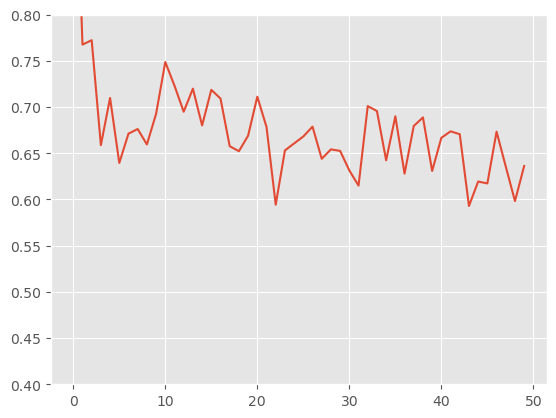

RMSE nach 10 Epochen:
Trainings-RMSE: 0.5983
Test-RMSE: 0.6363

 Training mit Momentum = 0.5
[Epoche 1 | Batch Nr. 0] RMSE (Train): 1.0017
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.7548
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.6582
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.7266
==> Epoche 1: RMSE (Test): 0.6844
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.6469
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.6758
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.6941
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.6874
==> Epoche 2: RMSE (Test): 0.6638
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.6732
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.6496
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.6768
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.6098
==> Epoche 3: RMSE (Test): 0.6415
[Epoche 4 | Batch Nr. 0] RMSE (Train): 0.6856
[Epoche 4 | Batch Nr. 500] RMSE (Train): 0.6214
[Epoche 4 | Batch Nr. 1000] RMSE (Train): 0.6029
[Epoche 4 | Batch Nr. 1500] RMSE (Train): 0.5903
==> Epoche 4: RMSE (Test): 0.6202
[Ep

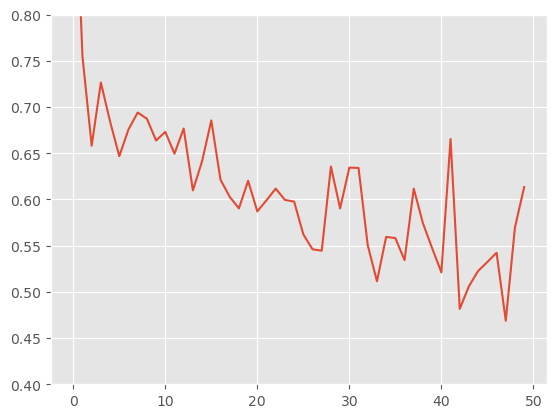


 Training mit Momentum = 0.8
[Epoche 1 | Batch Nr. 0] RMSE (Train): 1.0355
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.6672
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.6650
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.6204
==> Epoche 1: RMSE (Test): 0.6602
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.6945
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.6371
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.6633
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.6085
==> Epoche 2: RMSE (Test): 0.6203
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.6104
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.5497
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.6559
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.6058
==> Epoche 3: RMSE (Test): 0.5953
[Epoche 4 | Batch Nr. 0] RMSE (Train): 0.5737
[Epoche 4 | Batch Nr. 500] RMSE (Train): 0.6431
[Epoche 4 | Batch Nr. 1000] RMSE (Train): 0.5854
[Epoche 4 | Batch Nr. 1500] RMSE (Train): 0.5913
==> Epoche 4: RMSE (Test): 0.5671
[Epoche 5 | Batch Nr. 0] RMSE (Train): 0.6253
[Epoche 5 | Batch Nr

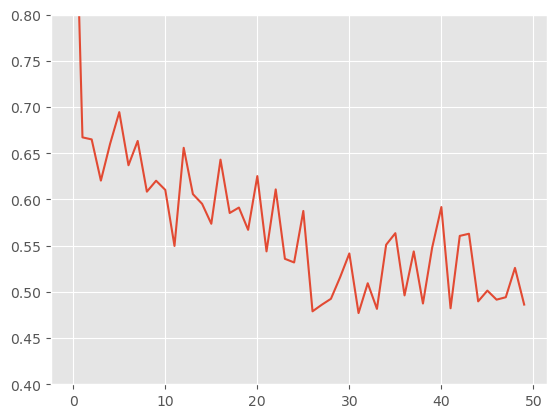


 Training mit Momentum = 0.9
[Epoche 1 | Batch Nr. 0] RMSE (Train): 0.9325
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.6552
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.6796
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.6555
==> Epoche 1: RMSE (Test): 0.6417
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.5934
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.6682
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.5591
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.5456
==> Epoche 2: RMSE (Test): 0.5461
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.6014
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.5343
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.5360
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.6068
==> Epoche 3: RMSE (Test): 0.5277
[Epoche 4 | Batch Nr. 0] RMSE (Train): 0.5694
[Epoche 4 | Batch Nr. 500] RMSE (Train): 0.5780
[Epoche 4 | Batch Nr. 1000] RMSE (Train): 0.5144
[Epoche 4 | Batch Nr. 1500] RMSE (Train): 0.6066
==> Epoche 4: RMSE (Test): 0.5305
[Epoche 5 | Batch Nr. 0] RMSE (Train): 0.5584
[Epoche 5 | Batch Nr

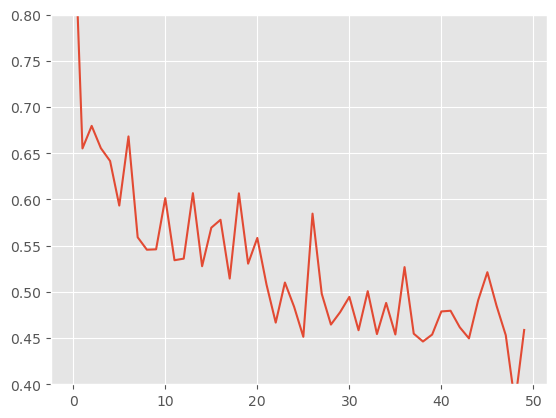


 Training mit Momentum = 0.99
[Epoche 1 | Batch Nr. 0] RMSE (Train): 0.9675
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.7425
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.6623
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.6003
==> Epoche 1: RMSE (Test): 0.5892
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.5233
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.5990
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.6002
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.5277
==> Epoche 2: RMSE (Test): 0.5891
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.5521
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.5541
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.5757
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.5277
==> Epoche 3: RMSE (Test): 0.5672
[Epoche 4 | Batch Nr. 0] RMSE (Train): 0.6087
[Epoche 4 | Batch Nr. 500] RMSE (Train): 0.5721
[Epoche 4 | Batch Nr. 1000] RMSE (Train): 0.5050
[Epoche 4 | Batch Nr. 1500] RMSE (Train): 0.5023
==> Epoche 4: RMSE (Test): 0.5186
[Epoche 5 | Batch Nr. 0] RMSE (Train): 0.5073
[Epoche 5 | Batch N

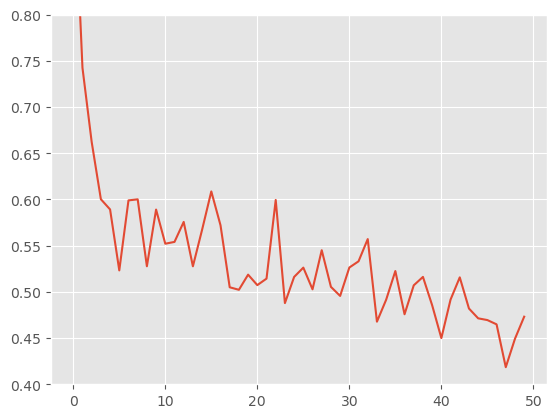


Vergleich der finalen RMSEs nach 10 Epochen (mit Momentum):
Momentum = 0.5: Train-RMSE = 0.5699 | Test-RMSE = 0.6134
Momentum = 0.8: Train-RMSE = 0.5260 | Test-RMSE = 0.4863
Momentum = 0.9: Train-RMSE = 0.3796 | Test-RMSE = 0.4588
Momentum = 0.99: Train-RMSE = 0.4493 | Test-RMSE = 0.4731

Training mit RMSprop
[Epoche 1 | Batch Nr. 0] RMSE (Train): 1.0376
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.5883
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.5528
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.6858
==> Epoche 1: RMSE (Test): 0.6154
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.6465
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.5234
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.6264
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.5917
==> Epoche 2: RMSE (Test): 0.6295
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.6494
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.6580
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.5267
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.5375
==> Epoche 3: RMSE (Test): 0.5421
[Epoche 4 

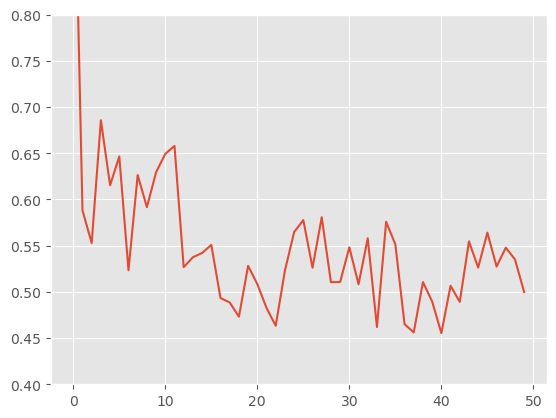


Training mit Adam
[Epoche 1 | Batch Nr. 0] RMSE (Train): 1.0121
[Epoche 1 | Batch Nr. 500] RMSE (Train): 0.6932
[Epoche 1 | Batch Nr. 1000] RMSE (Train): 0.6058
[Epoche 1 | Batch Nr. 1500] RMSE (Train): 0.4819
==> Epoche 1: RMSE (Test): 0.5651
[Epoche 2 | Batch Nr. 0] RMSE (Train): 0.5326
[Epoche 2 | Batch Nr. 500] RMSE (Train): 0.4869
[Epoche 2 | Batch Nr. 1000] RMSE (Train): 0.5048
[Epoche 2 | Batch Nr. 1500] RMSE (Train): 0.4954
==> Epoche 2: RMSE (Test): 0.4907
[Epoche 3 | Batch Nr. 0] RMSE (Train): 0.4454
[Epoche 3 | Batch Nr. 500] RMSE (Train): 0.5170
[Epoche 3 | Batch Nr. 1000] RMSE (Train): 0.5436
[Epoche 3 | Batch Nr. 1500] RMSE (Train): 0.4987
==> Epoche 3: RMSE (Test): 0.5006
[Epoche 4 | Batch Nr. 0] RMSE (Train): 0.5112
[Epoche 4 | Batch Nr. 500] RMSE (Train): 0.4869
[Epoche 4 | Batch Nr. 1000] RMSE (Train): 0.4250
[Epoche 4 | Batch Nr. 1500] RMSE (Train): 0.4751
==> Epoche 4: RMSE (Test): 0.4654
[Epoche 5 | Batch Nr. 0] RMSE (Train): 0.4695
[Epoche 5 | Batch Nr. 500] RMSE

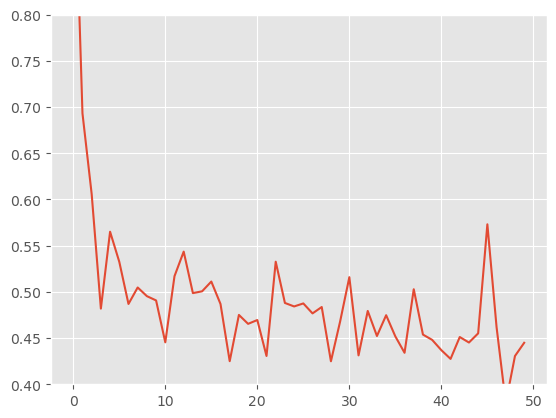


Vergleich RMSprop & Adam:
RMSprop: Train-RMSE = 0.5351 | Test-RMSE = 0.4998
Adam: Train-RMSE = 0.4306 | Test-RMSE = 0.4449


In [4]:
# Zusatzaufgabe:
def generate_batches(batch_size, n_samples):
    indices = np.random.permutation(n_samples)
    return [indices[i:i + batch_size] for i in range(0, n_samples, batch_size)]


#Aufgabe 1.1

data = torch.load("./Daten Blatt 2/electric_motor_temp_data_norm",weights_only=False)

train_data = data["train_data"]
test_data = data["test_data"]

print("Größe des Trainingsdatensatzes:", len(train_data))

#Aufgabe 1.2

def train_model(network, train_data, test_data, optimizer, criterion, 
                batch_size, epochs, log_interval):
    full_log = []

    n_samples = len(train_data)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

    batch_rmse_log = []
    test_rmse_log = []

    for epoch in range(epochs):
        network.train()
        batches = generate_batches(batch_size, n_samples)

        for batch_idx, batch_indices in enumerate(batches):
            batch = [train_data[i] for i in batch_indices]
            x = torch.stack([item[0] for item in batch])
            y = torch.stack([item[1] for item in batch])

            optimizer.zero_grad()
            output = network(x)
            loss = criterion(output, y.unsqueeze(1))
            loss.backward()
            optimizer.step()

            if batch_idx % log_interval == 0:
                rmse = torch.sqrt(loss).item()
                batch_rmse_log.append(rmse)
                full_log.append(rmse)
                print(f"[Epoche {epoch+1} | Batch Nr. {batch_idx}] RMSE (Train): {rmse:.4f}") 

        network.eval()
        test_loss = 0
        with torch.no_grad():
            for x_test, y_test in test_loader:
                output = network(x_test)
                test_loss += criterion(output, y_test.unsqueeze(1)).item()
            
            test_loss /= len(test_loader)
            test_rmse = np.sqrt(test_loss)
            test_rmse_log.append(test_rmse)
            full_log.append(test_rmse)
            print(f"==> Epoche {epoch+1}: RMSE (Test): {test_rmse:.4f}") 

    plt.plot(full_log)
    plt.grid(True)
    plt.ylim(0.4, 0.8)
    plt.show()
    
    return batch_rmse_log, test_rmse_log


#Aufgabe 1.3
network = Net()
criterion = net.MSELoss()
optimizer = torch.optim.SGD(network.parameters(), lr=learning_rate)

batch_rmse_log, test_rmse_log = train_model(network, train_data, test_data, optimizer, criterion, batch_size=batch_size, epochs=n_epochs, log_interval=log_interval)

print("RMSE nach 10 Epochen:")
print(f"Trainings-RMSE: {batch_rmse_log[-1]:.4f}")
print(f"Test-RMSE: {test_rmse_log[-1]:.4f}")


#Aufgabe 1.4
momentum_values = [0.5, 0.8, 0.9, 0.99]
results = {}

for momentum in momentum_values:
    print(f"\n Training mit Momentum = {momentum}")
    
    network_momentum = Net()
    criterion = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(network_momentum.parameters(), lr=learning_rate, momentum=momentum) #SGD mit Momentum 
    
    batch_rmse_log, test_rmse_log = train_model(network_momentum, train_data, test_data, optimizer, criterion, batch_size=batch_size, epochs=n_epochs, log_interval=log_interval)
    
    results[momentum] = {'train': batch_rmse_log[-1], 'test': test_rmse_log[-1]}

print("\nVergleich der finalen RMSEs nach 10 Epochen (mit Momentum):")
for m, values in results.items():
    print(f"Momentum = {m}: Train-RMSE = {values['train']:.4f} | Test-RMSE = {values['test']:.4f}")


#Aufgabe 1.5

optimizers = {'RMSprop': torch.optim.RMSprop, 'Adam': torch.optim.Adam}

results_optimizers = {}

for name, optim_class in optimizers.items():
    print(f"\nTraining mit {name}")
    
    network_adam_and_RMS = Net()
    criterion = torch.nn.MSELoss()
    optimizer = optim_class(network_adam_and_RMS.parameters(), lr=learning_rate)
    
    batch_rmse_log, test_rmse_log = train_model(network_adam_and_RMS, train_data, test_data, optimizer, criterion, batch_size=batch_size, epochs=n_epochs, log_interval=log_interval)
    
    results_optimizers[name] = {'train': batch_rmse_log[-1], 'test': test_rmse_log[-1]}

print("\nVergleich RMSprop & Adam:")
for name, values in results_optimizers.items():
    print(f"{name}: Train-RMSE = {values['train']:.4f} | Test-RMSE = {values['test']:.4f}")


Zu 1.4:

Kategorie|Ohne Momentum|Momentum 0.5 | Momentum 0.8 | Momentum 0.9 | Momentum 0.99
----|-----|-----|-|-|-|
Test RMSE nach 10 Epochen | 0.6363|0.6134|0.4863|0.4588|0.4731
Trainingskurve|Die Kurve fällt eher langsam und stagniert|Kurve fällt anfangs stärker; behält einen stärkeren Fall bei und erreicht einen geringeren Loss |Kurve fällt anfangs stärker; behält einen stärkeren Fall bei und erreicht einen geringeren Loss |Kurve fällt anfangs stärker; behält einen stärkeren Fall bei und erreicht einen geringeren Loss | Kurve fällt anfangs stärker; behält einen stärkeren Fall bei und erreicht einen geringeren Loss; etwas schlechterer Loss als bei Momentum 0.9 |

Zusammenfassend lässt sich sagen, dass die Ergebnisse bei stärkerem Einbeziehen der vorgänger Terme, also stärkerem Momentum bessere Endergebnisse erzielt werden können. Darüber hinaus fällt die Kurve bei mehr Momentum zu Beginn des Trainings - proportional zum Momentum - mehr und erreicht geringere End Losswerte. Beim letzten Momentumwert ist eine leichte Verschlechterung des Endlosses zu beobachten.




Zu 1.5:</br>
RMSProp lernt schneller (vergleiche Kurven) und besser als SGD (End RMSE bei 0.4998 zu 0.6363) bleibt jedoch über dem durch Momentum mit 0.9 erreichten RMSE von 0.4588. Das könnte möglicherweise daran liegen, dass durch das Momentum stärker gesprungen wird. 

Adam lernt ebenfalls schneller (vergleiche Kurven) und besser als SGD (End RMSE bei 0.4449 zu 0.6363) und verbessert sich auch gegenüber dem von Momentum mit 0.9 erreichten Loss von 0.4588. Auch lernt es stabiler als RMSProp (weniger Schwankung in den Losses).

Die bessere Performance der drei Methoden lässt sich möglicherweise dadurch erklären, dass die Methoden Sattelpunkte besser vermeiden können als reines SGD.